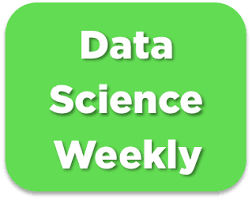

# Challenge : predict conversions 🏆🏆

This is the template that shows the different steps of the challenge. In this notebook, all the training/predictions steps are implemented for a very basic model (logistic regression with only one variable). Please use this template and feel free to change the preprocessing/training steps to get the model with the best f1-score ! May the force be with you 🧨🧨  

**For a detailed description of this project, please refer to *02-Conversion_rate_challenge.ipynb*.**

# Import libraries

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay, RocCurveDisplay
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import plotly.io as pio

from IPython.display import display

# Read file with labels

In [2]:
data = pd.read_csv('conversion_data_train.csv')
print('Set with labels (our train+test) :', data.shape)

Set with labels (our train+test) : (284580, 6)


In [3]:
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


# Project

<div align="Justify">

We'll be looking at user data from the www.datascienceweekly.org website. The aim is to help the data scientists who created the newsletter to analyze their users' behavior and define the parameters that could improve the conversion rate into newsletter subscriptions.

First, we'll explore the dataset to see which variable has the greatest influence on the conversion rate, in order to create a baseline. This is a classification problem. The target variable is 0 or 1, corresponding to whether or not users subscribe to the newsletter.

</div>

# Data Exploration

In [ ]:
data.describe(include='all')

,country,age,new_user,source,total_pages_visited,converted
count,284580,284580.000000,284580.000000,284580,284580.000000,284580.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,160124,NaN,NaN,139477,NaN,NaN
mean,NaN,30.564203,0.685452,NaN,4.873252,0.032258
std,NaN,8.266789,0.464336,NaN,3.341995,0.176685
min,NaN,17.000000,0.000000,NaN,1.000000,0.000000
25%,NaN,24.000000,0.000000,NaN,2.000000,0.000000
50%,NaN,30.000000,1.000000,NaN,4.000000,0.000000
75%,NaN,36.000000,1.000000,NaN,7.000000,0.000000


In [ ]:
# The dataset is quite big : we must create a sample of the dataset for some visualizations
data_sample = data.sample(10000)

In [ ]:
data['converted'].value_counts()

0    275400
1      9180
Name: converted, dtype: int64

<div align="Justify">

We have a dataset with over 284,000 rows, the target variable corresponding to the 'converted' column, and 5 columns with explanatory variables. Categorical variables such as the user's country, the source of the user's visit, whether the user came to the site directly, through page positioning (SEO) or through advertising. We also know if the user is new to the site. As a numerical variable, we have the user's age and the number of pages visited on the site.

In this table, we can see that there are no missing values, but there are several tools in the data. For example, we have ages up to 123 for the age or 29 pages visited.  We can also see that the conversion rate is around 3% of all website visitors. This is a fairly low rate. We have an unbalanced dataset, which will be taken into account when creating the model.

</div>

## individual variable

In [ ]:
data['converted'].value_counts()

0    275400
1      9180
Name: converted, dtype: int64

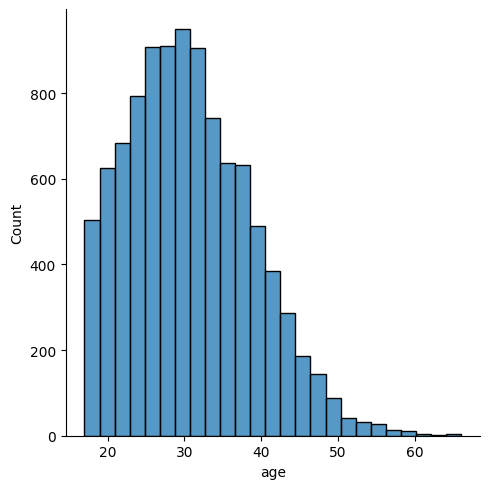

In [ ]:
sns.displot(data_sample['age'], bins=25)

<Axes: >

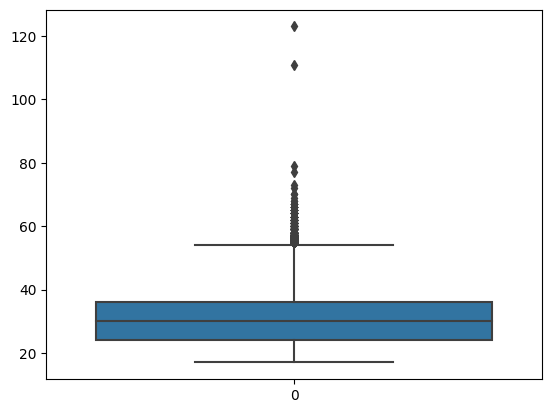

In [ ]:
sns.boxplot(data['age'])

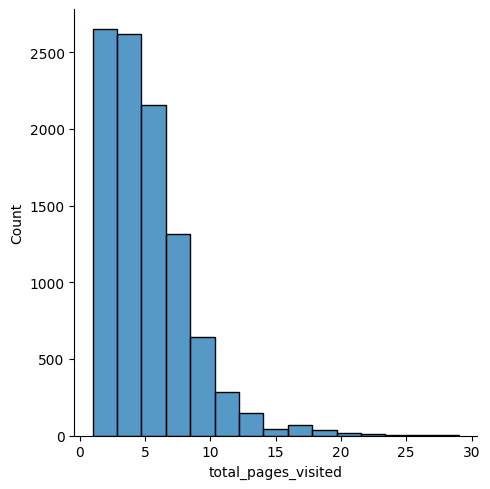

In [ ]:
sns.displot(data_sample['total_pages_visited'], bins=15)

<Axes: >

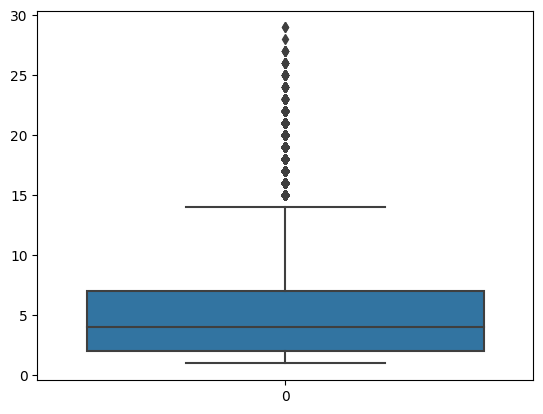

In [ ]:
sns.boxplot(data['total_pages_visited'])

<Axes: xlabel='country', ylabel='Count'>

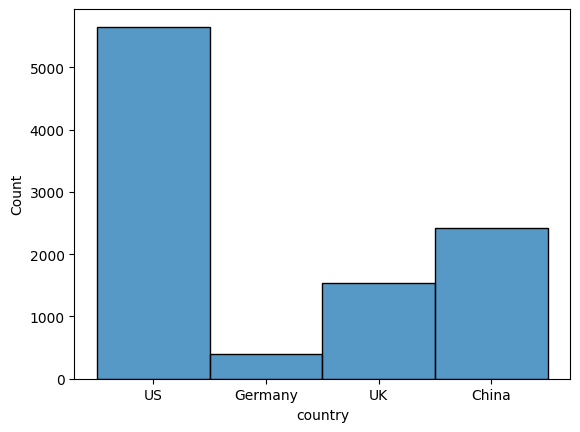

In [ ]:
sns.histplot(data_sample['country'])

<Axes: xlabel='source', ylabel='Count'>

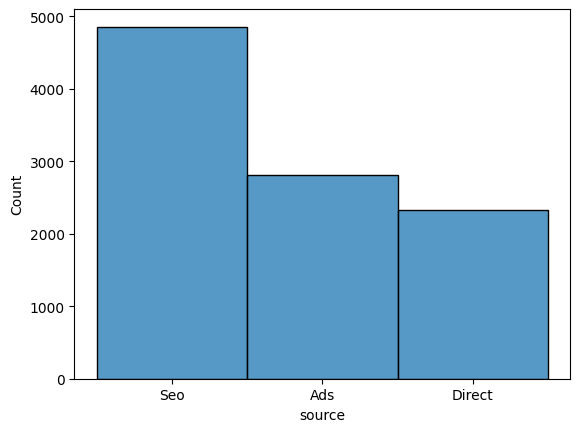

In [ ]:
sns.histplot(data_sample['source'])

 ## Conversion analysis

In [ ]:
# Visualize pairwise dependencies
fig = px.scatter_matrix(data_sample)
fig.update_layout(
        title = go.layout.Title(text = "Bivariate analysis", x = 1), showlegend = False,
            autosize=False, height=1000, width = 1000)
fig.show()

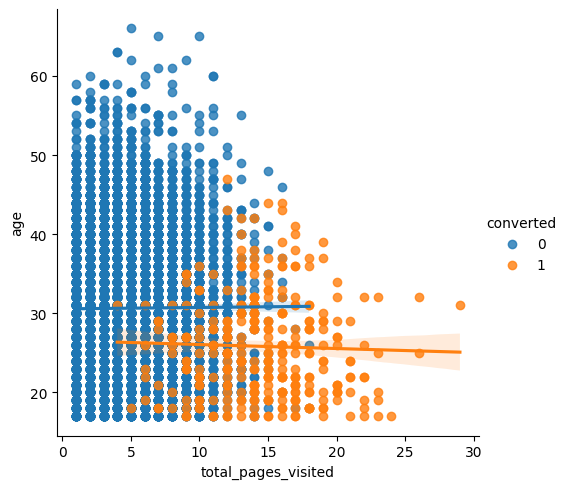

In [ ]:
sns.lmplot(x='total_pages_visited', y='age', hue="converted", data=data_sample)

In [ ]:
data['country'].value_counts()

US         160124
China       69122
UK          43641
Germany     11693
Name: country, dtype: int64

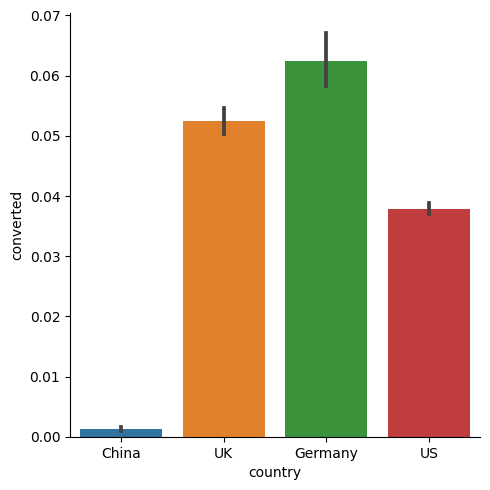

In [ ]:
sns.catplot(x="country", y="converted", kind="bar", data=data)

In [ ]:
data['source'].value_counts()

Seo       139477
Ads        80027
Direct     65076
Name: source, dtype: int64

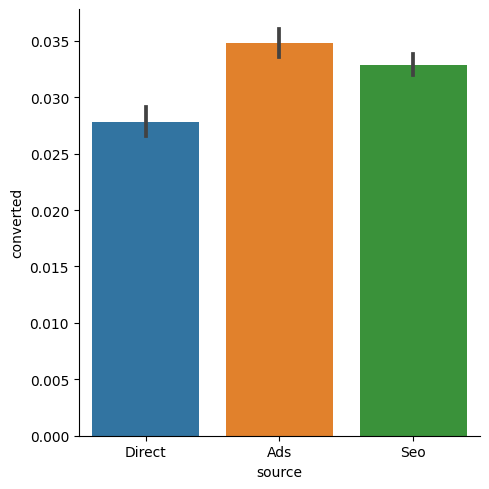

In [ ]:
sns.catplot(x="source", y="converted", kind="bar", data=data)

In [ ]:
data['new_user'].value_counts()

1    195066
0     89514
Name: new_user, dtype: int64

In [ ]:
195066/284580

0.6854522454142947

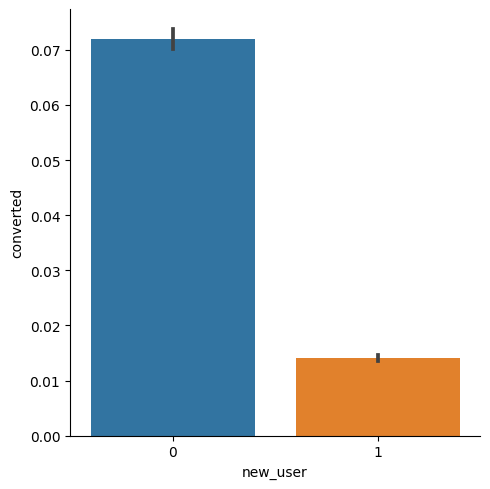

In [ ]:
sns.catplot(x="new_user", y="converted", kind="bar", data=data)

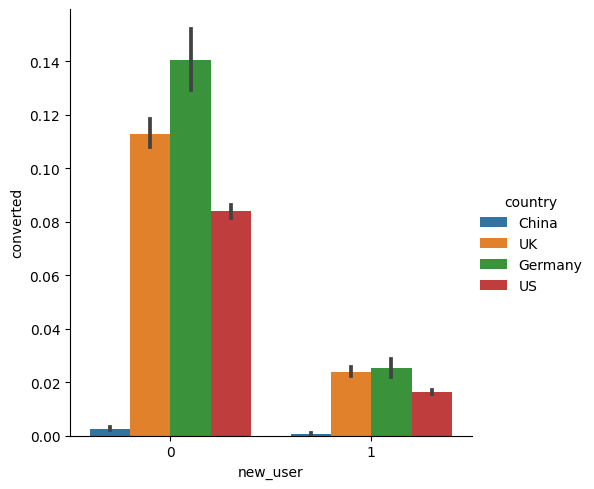

In [ ]:
sns.catplot(x="new_user", y="converted", kind="bar", hue="country", data=data)

In [ ]:
data_sample.columns

Index(['country', 'age', 'new_user', 'source', 'total_pages_visited',
       'converted'],
      dtype='object')

In [ ]:
data_sample_num = pd.DataFrame(data_sample.iloc[:,[1,2,4,5]])

In [ ]:
data_sample_num.columns

Index(['age', 'new_user', 'total_pages_visited', 'converted'], dtype='object')

In [ ]:
correlation = data_sample_num.corr()

<Axes: >

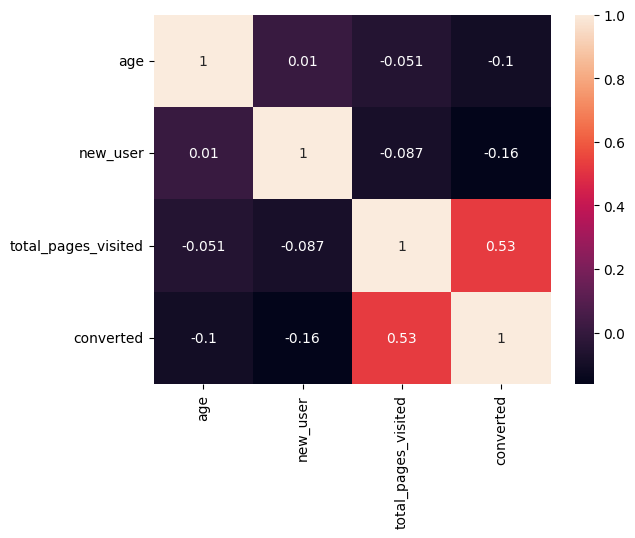

In [ ]:
sns.heatmap(correlation, annot=True)

## **Analysis :**

<div align="Justify">

In this part, we can see that users over 55 and people who have visited more than 15 pages are considered outliers. There is a tendency for young people to view more pages than older people.
A large proportion of users come from the US, followed by China, but few from Europe. However, the conversion rate is better among Europeans.

The majority of users come from page referencing (seo). But the most conversions come from people coming through ads.
We have more than two-thirds new users, but it's not among new users that we have the most subscriptions.

In the correlation matrix, we can see that subscriptions correlate strongly with the number of pages visited. So we'll base our baseline on this variable first.


</div>

# Baseline Logistic Regression with number of total pages visited

## Preprocessing

In [ ]:
# selection feature
features_list = ['total_pages_visited']
target_variable = 'converted'

X = data.loc[:, features_list]
Y = data.loc[:, target_variable]

print('Explanatory variables : ', X.columns)
print()

Explanatory variables :  Index(['total_pages_visited'], dtype='object')



In [ ]:
# Divide dataset Train set & Test set
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=0, stratify=Y)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [ ]:
# Convert pandas DataFrames to numpy arrays before using scikit-learn
print("Convert pandas DataFrames to numpy arrays...")
X_train = X_train.values
X_test = X_test.values
Y_train = Y_train.values
Y_test = Y_test.values
print("...Done")

print(X_train[0:5,:])
print(X_test[0:2,:])
print()
print(Y_train[0:5])
print(Y_test[0:2])

Convert pandas DataFrames to numpy arrays...
...Done
[[2]
 [2]
 [7]
 [3]
 [8]]
[[14]
 [ 5]]

[0 0 0 0 0]
[0 0]


In [ ]:
# standardizing number pages visited features
print("Standardizing numerical features...")

featureencoder = StandardScaler()
X_train = featureencoder.fit_transform(X_train)
print("...Done")
print(X_train[0:5,:])

Standardizing numerical features...
...Done
[[-0.85939501]
 [-0.85939501]
 [ 0.63639894]
 [-0.56023622]
 [ 0.93555773]]


## Model

In [ ]:
# Train model
print("Train model...")
classifier = LogisticRegression() #
classifier.fit(X_train, Y_train)
print("...Done.")

Train model...
...Done.


In [ ]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = classifier.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]



In [ ]:
# Use X_test, and the same preprocessings as in training pipeline,

print("Encoding categorical features and standardizing numerical features...")

X_test = featureencoder.transform(X_test)
print("...Done")
print(X_test[0:5,:])

Encoding categorical features and standardizing numerical features...
...Done
[[ 2.73051047]
 [ 0.03808136]
 [-0.26107743]
 [ 0.93555773]
 [-0.85939501]]


In [ ]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = classifier.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on test set...
...Done.
[1 0 0 ... 0 0 0]



## Performance assessment

In [ ]:
# WARNING : Use the same score as the one that will be used by Kaggle !
# Here, the f1-score will be used to assess the performances on the leaderboard
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on train set :  0.6971029668411867
f1-score on test set :  0.6771951989892608


In [ ]:
# You can also check more performance metrics to better understand what your model is doing
print("Confusion matrix on train set : ")
print(confusion_matrix(Y_train, Y_train_pred))
print()
print("Confusion matrix on test set : ")
print(confusion_matrix(Y_test, Y_test_pred))
print()

Confusion matrix on train set : 
[[246790   1070]
 [  3269   4993]]

Confusion matrix on test set : 
[[27411   129]
 [  382   536]]



##  Train best classifier on all data and use it to make predictions on X_without_labels
**Before making predictions on the file conversion_data_test.csv, let's train our model on ALL the data that was in conversion_data_train.csv. Sometimes, this allows to make tiny improvements in the score because we're using more examples to train the model.**

In [ ]:
# Concatenate our train and test set to train your best classifier on all data with labels
X = np.append(X_train,X_test,axis=0)
Y = np.append(Y_train,Y_test)

classifier.fit(X,Y)

LogisticRegression()

In [ ]:
# Read data without labels
data_without_labels = pd.read_csv('conversion_data_test.csv')
print('Prediction set (without labels) :', data_without_labels.shape)

# Warning : check consistency of features_list (must be the same than the features
# used by your best classifier)
features_list = ['total_pages_visited']
X_without_labels = data_without_labels.loc[:, features_list]

# Convert pandas DataFrames to numpy arrays before using scikit-learn
print("Convert pandas DataFrames to numpy arrays...")
X_without_labels = X_without_labels.values
print("...Done")

print(X_without_labels[0:5,:])

Prediction set (without labels) : (31620, 5)
Convert pandas DataFrames to numpy arrays...
...Done
[[16]
 [ 5]
 [ 1]
 [ 6]
 [ 3]]


In [ ]:
# WARNING : PUT HERE THE SAME PREPROCESSING AS FOR YOUR TEST SET
# CHECK YOU ARE USING X_without_labels
print("Encoding categorical features and standardizing numerical features...")

X_without_labels = featureencoder.transform(X_without_labels)
print("...Done")
print(X_without_labels[0:5,:])

Encoding categorical features and standardizing numerical features...
...Done
[[ 3.32882805]
 [ 0.03808136]
 [-1.1585538 ]
 [ 0.33724015]
 [-0.56023622]]


In [ ]:
# Make predictions and dump to file
# WARNING : MAKE SURE THE FILE IS A CSV WITH ONE COLUMN NAMED 'converted' AND NO INDEX !
# WARNING : FILE NAME MUST HAVE FORMAT 'conversion_data_test_predictions_[name].csv'
# where [name] is the name of your team/model separated by a '-'
# For example : [name] = AURELIE-model1
data_baseline = {
    'converted': classifier.predict(X_without_labels)
}

Y_predictions = pd.DataFrame(columns=['converted'],data=data_baseline)
Y_predictions.to_csv('conversion_data_test_predictions_Juliette-Baseline.csv', index=False)

## Baseline analysis

<div align="Justify">

As seen above, we perform the baseline with a simple one-variable logistic regression, which is the number of pages visited. Because it's the variable most correlated with newsletter subscription. As we have an unbalanced dataset, we stratify the split test train for the model (in this notebook, we'll do this for all models in the future).

This first very simple model already achieves an F1-score of 0.69 on the train set and 0.67 on the test set. This is already very good for a baseline with a single variable.

For this baseline, I left the entire dataset. I also tried with only the number of pages below 15, but this gave a very poor result with an F1 score of 0.46. This is lower than the model with the outliers.

For the following models, I made several attempts and decided to keep the version where I only removed the outliers, people over 100 and the total number of pages visited over 25.

</div>

# Logistic regression with all features

## preprocessing

In [4]:
data_lr = data.loc[(data['age'] <= 100) & (data['total_pages_visited']<=25) , :]
data_lr.describe(include='all')

,country,age,new_user,source,total_pages_visited,converted
count,284553,284553.000000,284553.000000,284553,284553.000000,284553.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,160108,NaN,NaN,139467,NaN,NaN
mean,NaN,30.564067,0.685489,NaN,4.871289,0.032166
std,NaN,8.263641,0.464322,NaN,3.335864,0.176442
min,NaN,17.000000,0.000000,NaN,1.000000,0.000000
25%,NaN,24.000000,0.000000,NaN,2.000000,0.000000
50%,NaN,30.000000,1.000000,NaN,4.000000,0.000000
75%,NaN,36.000000,1.000000,NaN,7.000000,0.000000


In [ ]:
# Separate target variable Y from features X
print("Separating labels from features...")
features_list = ["country", "age", "total_pages_visited", "new_user", "source"]
target_variable = "converted"

X = data_lr.loc[:, features_list]
Y = data_lr.loc[:,target_variable]

print("...Done.")
print()

print('Y : ')
print(Y.head())
print()
print('X :')
print(X.head())

Separating labels from features...
...Done.

Y : 
0    0
1    0
2    1
3    0
4    0
Name: converted, dtype: int64

X :
   country  age  total_pages_visited  new_user  source
0    China   22                    2         1  Direct
1       UK   21                    3         1     Ads
2  Germany   20                   14         0     Seo
3       US   23                    3         1     Seo
4       US   28                    3         1  Direct


In [ ]:
numeric_features = ['age', 'total_pages_visited']
categorical_features = ['country', 'new_user', "source"]

In [ ]:
# Divide dataset Train set & Test set
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=120, stratify=Y)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [ ]:
# Create pipeline for numeric features
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Create pipeline for categorical features
categorical_transformer = Pipeline(
    steps=[
    ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ])

# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [ ]:
# Preprocessings on train set
print("Performing preprocessings on train set...")
print(X_train.head())
X_train = preprocessor.fit_transform(X_train)
print('...Done.')
print(X_train[0:5]) # MUST use this syntax because X_train is a numpy array and not a pandas DataFrame anymore
print()

# Preprocessings on test set
print("Performing preprocessings on test set...")
print(X_test.head())
X_test = preprocessor.transform(X_test) # Don't fit again !! The test set is used for validating decisions
# we made based on the training set, therefore we can only apply transformations that were parametered using the training set.
# Otherwise this creates what is called a leak from the test set which will introduce a bias in all your results.
print('...Done.')
print(X_test[0:5,:]) # MUST use this syntax because X_test is a numpy array and not a pandas DataFrame anymore
print()

Performing preprocessings on train set...
       country  age  total_pages_visited  new_user  source
274066      US   32                    9         0     Seo
175882      US   29                   14         1     Ads
206128      US   21                    8         0  Direct
187979   China   30                    1         1     Seo
39082       US   28                    1         1     Seo
...Done.
[[ 0.17402829  1.23698407  0.          0.          1.          0.
   0.          1.        ]
 [-0.18908503  2.73525975  0.          0.          1.          1.
   0.          0.        ]
 [-1.15738722  0.93732893  0.          0.          1.          0.
   1.          0.        ]
 [-0.06804726 -1.16025702  0.          0.          0.          1.
   0.          1.        ]
 [-0.31012281 -1.16025702  0.          0.          1.          1.
   0.          1.        ]]

Performing preprocessings on test set...
       country  age  total_pages_visited  new_user source
159597      US   26          

## Model

In [ ]:
# Train model
print("Train model...")
regressor = LogisticRegression()
regressor.fit(X_train, Y_train)
print("...Done.")

Train model...
...Done.


In [ ]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = regressor.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]



In [ ]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = regressor.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]



## Performance assessment

In [ ]:
# WARNING : Use the same score as the one that will be used by Kaggle !
# Here, the f1-score will be used to assess the performances on the leaderboard
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on train set :  0.7610753502461187
f1-score on test set :  0.7689050211736237


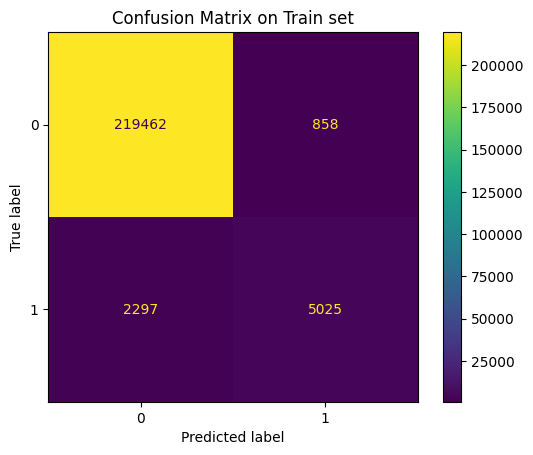

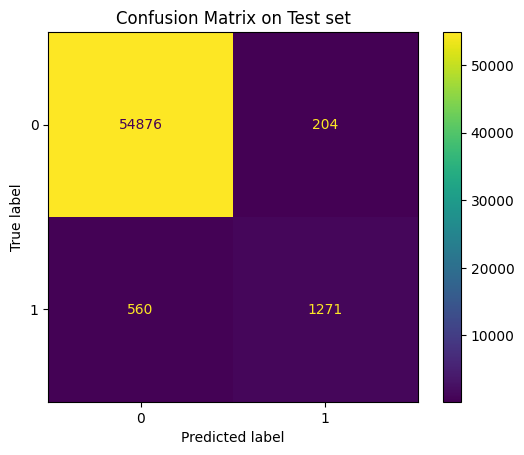

In [ ]:
# Visualize confusion matrices
_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Train set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(regressor, X_train, Y_train, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Test set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(regressor, X_test, Y_test, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

In [ ]:
regressor.coef_

array([[-0.6117994 ,  2.52350468,  3.60814042,  3.48425005,  3.12572597,
        -1.68634021, -0.18823549, -0.00764046]])

In [ ]:
column_names = []
for name, pipeline, features_list in preprocessor.transformers_: # loop over pipelines
    if name == 'num': # if pipeline is for numeric variables
        features = features_list # just get the names of columns to which it has been applied
    else: # if pipeline is for categorical variables
        features = pipeline.named_steps['encoder'].get_feature_names_out() # get output columns names from OneHotEncoder
    column_names.extend(features) # concatenate features names

print("Names of columns corresponding to each coefficient: ", column_names)

Names of columns corresponding to each coefficient:  ['age', 'total_pages_visited', 'country_Germany', 'country_UK', 'country_US', 'new_user_1', 'source_Direct', 'source_Seo']


In [ ]:
#Create a pandas DataFrame
coefs = pd.DataFrame(index = column_names, data = regressor.coef_.transpose(), columns=["coefficients"])
coefs

,coefficients
age,-0.611799
total_pages_visited,2.523505
country_Germany,3.608140
country_UK,3.484250
country_US,3.125726
new_user_1,-1.686340
source_Direct,-0.188235
source_Seo,-0.007640


In [ ]:
# Compute abs() and sort values
feature_importance = abs(coefs).sort_values(by = 'coefficients')
feature_importance

,coefficients
source_Seo,0.007640
source_Direct,0.188235
age,0.611799
new_user_1,1.686340
total_pages_visited,2.523505
country_US,3.125726
country_UK,3.484250
country_Germany,3.608140


In [ ]:
# Plot coefficients
fig = px.bar(feature_importance, orientation = 'h')
fig.update_layout(showlegend = False,
                  margin = {'l': 120} # to avoid cropping of column names
                 )
fig.show()

## Train best classifier on all data and use it to make predictions on X_without_labels
**Before making predictions on the file conversion_data_test.csv, let's train our model on ALL the data that was in conversion_data_train.csv. Sometimes, this allows to make tiny improvements in the score because we're using more examples to train the model.**

In [ ]:
# Concatenate our train and test set to train your best classifier on all data with labels
X = np.append(X_train,X_test,axis=0)
Y = np.append(Y_train,Y_test)

regressor.fit(X,Y)

LogisticRegression()

In [ ]:
# Read data without labels
data_without_labels = pd.read_csv('conversion_data_test.csv')
print('Prediction set (without labels) :', data_without_labels.shape)

# Warning : check consistency of features_list (must be the same than the features
# used by your best classifier)
features_list = ["country", "age", "total_pages_visited", "new_user", "source"]
X_without_labels = data_without_labels.loc[:, features_list]

# Convert pandas DataFrames to numpy arrays before using scikit-learn
print("Convert pandas DataFrames to numpy arrays...")
#X_without_labels = X_without_labels.values
print("...Done")

print(X_without_labels.head())

Prediction set (without labels) : (31620, 5)
Convert pandas DataFrames to numpy arrays...
...Done
  country  age  total_pages_visited  new_user  source
0      UK   28                   16         0     Seo
1      UK   22                    5         1  Direct
2   China   32                    1         1     Seo
3      US   32                    6         1     Ads
4   China   25                    3         0     Seo


In [ ]:
# WARNING : PUT HERE THE SAME PREPROCESSING AS FOR YOUR TEST SET
# CHECK YOU ARE USING X_without_labels
print("Encoding categorical features and standardizing numerical features...")

X_without_labels = preprocessor.transform(X_without_labels)
print("...Done")
print(X_without_labels[0:5,:])

Encoding categorical features and standardizing numerical features...
...Done
[[-0.31012281  3.33457002  0.          1.          0.          0.
   0.          1.        ]
 [-1.03634945  0.03836352  0.          1.          0.          1.
   1.          0.        ]
 [ 0.17402829 -1.16025702  0.          0.          0.          1.
   0.          1.        ]
 [ 0.17402829  0.33801866  0.          0.          1.          1.
   0.          0.        ]
 [-0.67323613 -0.56094675  0.          0.          0.          0.
   0.          1.        ]]


In [ ]:
# Make predictions and dump to file
# WARNING : MAKE SURE THE FILE IS A CSV WITH ONE COLUMN NAMED 'converted' AND NO INDEX !
# WARNING : FILE NAME MUST HAVE FORMAT 'conversion_data_test_predictions_[name].csv'
# where [name] is the name of your team/model separated by a '-'
# For example : [name] = AURELIE-model1
data_regression = {
    'converted': regressor.predict(X_without_labels)
}

Y_predictions = pd.DataFrame(columns=['converted'],data=data_regression)
Y_predictions.to_csv('conversion_data_test_predictions_Juliette-regression.csv', index=False)

## Logistic regression with all features analysis

<div align="Justify">

Following the baseline, the aim was to make the model more complex by adding variables to see if we could improve the F1-score. I tried a logistic regression model, including all the variables in X. The F1-score rose from 0.69 to 0.76 on the train set and from 0.67 to 0.76 on the test set. There is a clear improvement in the model if all variables are taken into account.

We can also look at the coefficients assigned to each variable. When all variables are taken into account, the model gives a lot of weight to the origin of the site's users, and the number of pages visited only comes in 4th place. Age has very small impact on the model's decision.

</div>

# Decision Tree

## Preprocessing

In [ ]:
# Separate target variable Y from features X
print("Separating labels from features...")
features_list = ["country", "age", "total_pages_visited", "source", "new_user"]
target_variable = "converted"

X = data_lr.loc[:,features_list]
Y = data_lr.loc[:,target_variable]

print("...Done.")
print()

print('Y : ')
print(Y.head())
print()
print('X :')
print(X.head())

Separating labels from features...
...Done.

Y : 
0    0
1    0
2    1
3    0
4    0
Name: converted, dtype: int64

X :
   country  age  total_pages_visited  source  new_user
0    China   22                    2  Direct         1
1       UK   21                    3     Ads         1
2  Germany   20                   14     Seo         0
3       US   23                    3     Seo         1
4       US   28                    3  Direct         1


In [ ]:
# Divide dataset Train set & Test set
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0, stratify=Y)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [ ]:
numeric_features = ['age', 'total_pages_visited']
categorical_features = ['country', 'new_user', "source"]

In [ ]:
# Create pipeline for categorical features
# Create pipeline for numeric features
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first') # first column will be dropped to avoid creating correlations between features

# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [ ]:
# Preprocessings on train set
print("Performing preprocessings on train set...")
print(X_train.head())
X_train = preprocessor.fit_transform(X_train)
print('...Done.')
print(X_train[0:5]) # MUST use this syntax because X_train is a numpy array and not a pandas DataFrame anymore
print()

# Preprocessings on test set
print("Performing preprocessings on test set...")
print(X_test.head())
X_test = preprocessor.transform(X_test) # Don't fit again !! The test set is used for validating decisions
# we made based on the training set, therefore we can only apply transformations that were parametered using the training set.
# Otherwise this creates what is called a leak from the test set which will introduce a bias in all your results.
print('...Done.')
print(X_test[0:5,:]) # MUST use this syntax because X_test is a numpy array and not a pandas DataFrame anymore
print()

Performing preprocessings on train set...
       country  age  total_pages_visited  source  new_user
68548       US   39                    5  Direct         1
171344      US   36                    6     Seo         1
52235       US   20                    7  Direct         0
2430     China   36                    6     Seo         0
55974       US   19                    9     Ads         1
...Done.
[[ 1.01894144  0.03804286  0.          0.          1.          1.
   1.          0.        ]
 [ 0.65613655  0.33776434  0.          0.          1.          1.
   0.          1.        ]
 [-1.27882289  0.63748583  0.          0.          1.          0.
   1.          0.        ]
 [ 0.65613655  0.33776434  0.          0.          0.          0.
   0.          1.        ]
 [-1.39975786  1.23692879  0.          0.          1.          1.
   0.          0.        ]]

Performing preprocessings on test set...
       country  age  total_pages_visited  source  new_user
18758       US   29         

## Model

In [ ]:
# Perform grid search
print("Grid search...")
dt = DecisionTreeClassifier()

# Grid of values to be tested
params = {
    'max_depth': [7,8,9,10,11,12],
    'min_samples_leaf': [1,2,3,7,8,9,10,11],
    'min_samples_split': [2,3]
}
gridsearch = GridSearchCV(dt, param_grid = params, cv = 5) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation accuracy : ", gridsearch.best_score_)

Grid search...
...Done.
Best hyperparameters :  {'max_depth': 8, 'min_samples_leaf': 9, 'min_samples_split': 3}
Best validation accuracy :  0.9855650540531284


## Performance assessment

In [ ]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = gridsearch.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

# It's also possible to get the probabilities estimated by the model:
print("Probabilities on training set...")
Y_train_proba = gridsearch.predict_proba(X_train)
print("...Done.")
print(Y_train_proba)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]

Probabilities on training set...
...Done.
[[9.99629046e-01 3.70954280e-04]
 [9.97587455e-01 2.41254524e-03]
 [9.83143282e-01 1.68567179e-02]
 ...
 [9.99979601e-01 2.03994207e-05]
 [9.96241433e-01 3.75856732e-03]
 [9.76709241e-01 2.32907588e-02]]



In [ ]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = gridsearch.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

# It's also possible to get the probabilities estimated by the model:
print("Probabilities on test set...")
Y_test_proba = gridsearch.predict_proba(X_test)
print("...Done.")
print(Y_test_proba)
print()

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]

Probabilities on test set...
...Done.
[[9.99736565e-01 2.63435195e-04]
 [9.99832580e-01 1.67420057e-04]
 [9.98113208e-01 1.88679245e-03]
 ...
 [1.00000000e+00 0.00000000e+00]
 [9.99979601e-01 2.03994207e-05]
 [1.00000000e+00 0.00000000e+00]]



In [ ]:
# Print scores
print("accuracy on training set : ", accuracy_score(Y_train, Y_train_pred))
print("accuracy on test set : ", accuracy_score(Y_test, Y_test_pred))
print()

print("f1-score on training set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))
print()

accuracy on training set :  0.9864699835706944
accuracy on test set :  0.9845548312277064

f1-score on training set :  0.7664543524416135
f1-score on test set :  0.7317668599328655



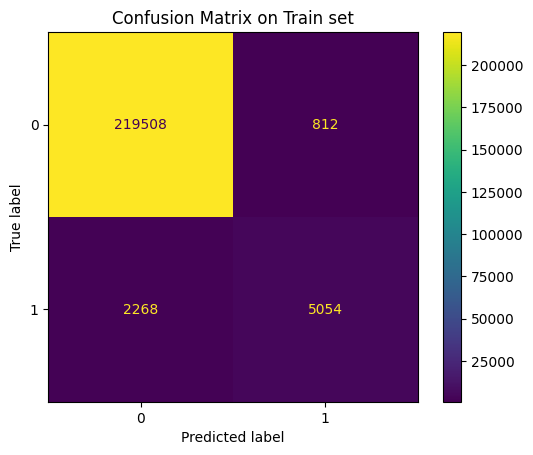

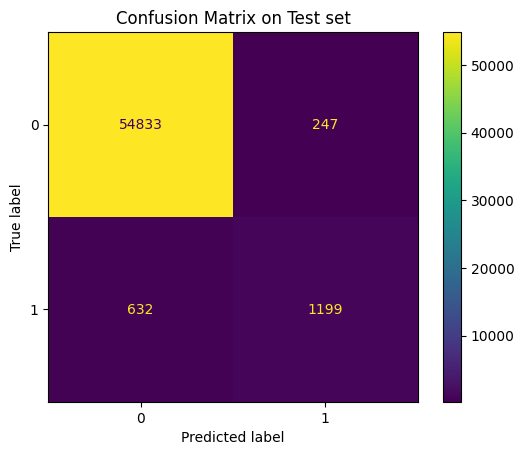

In [ ]:
# Visualize confusion matrices
_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Train set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(gridsearch, X_train, Y_train, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Test set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(gridsearch, X_test, Y_test, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

## Train best classifier on all data and use it to make predictions on X_without_labels
**Before making predictions on the file conversion_data_test.csv, let's train our model on ALL the data that was in conversion_data_train.csv. Sometimes, this allows to make tiny improvements in the score because we're using more examples to train the model.**

In [ ]:
# Concatenate our train and test set to train your best classifier on all data with labels
X = np.append(X_train,X_test,axis=0)
Y = np.append(Y_train,Y_test)

gridsearch.fit(X,Y)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [7, 8, 9, 10, 11, 12],
                         'min_samples_leaf': [7, 8, 9, 10, 11],
                         'min_samples_split': [2, 3]})

In [ ]:
# Read data without labels
data_without_labels = pd.read_csv('conversion_data_test.csv')
print('Prediction set (without labels) :', data_without_labels.shape)

# Warning : check consistency of features_list (must be the same than the features
# used by your best classifier)
features_list = ["country", "age", "total_pages_visited", "new_user", "source"]
X_without_labels = data_without_labels.loc[:, features_list]

# Convert pandas DataFrames to numpy arrays before using scikit-learn
print("Convert pandas DataFrames to numpy arrays...")
#X_without_labels = X_without_labels.values
print("...Done")

print(X_without_labels.head())

Prediction set (without labels) : (31620, 5)
Convert pandas DataFrames to numpy arrays...
...Done
  country  age  total_pages_visited  new_user  source
0      UK   28                   16         0     Seo
1      UK   22                    5         1  Direct
2   China   32                    1         1     Seo
3      US   32                    6         1     Ads
4   China   25                    3         0     Seo


In [ ]:
# WARNING : PUT HERE THE SAME PREPROCESSING AS FOR YOUR TEST SET
# CHECK YOU ARE USING X_without_labels
print("Encoding categorical features and standardizing numerical features...")

X_without_labels = preprocessor.transform(X_without_labels)
print("...Done")
print(X_without_labels[0:5,:])

Encoding categorical features and standardizing numerical features...
...Done
[[-0.31134317  3.33497917  0.          1.          0.          0.
   0.          1.        ]
 [-1.03695296  0.03804286  0.          1.          0.          1.
   1.          0.        ]
 [ 0.17239669 -1.16084307  0.          0.          0.          1.
   0.          1.        ]
 [ 0.17239669  0.33776434  0.          0.          1.          1.
   0.          0.        ]
 [-0.67414807 -0.56140011  0.          0.          0.          0.
   0.          1.        ]]


In [ ]:
# Make predictions and dump to file
# WARNING : MAKE SURE THE FILE IS A CSV WITH ONE COLUMN NAMED 'converted' AND NO INDEX !
# WARNING : FILE NAME MUST HAVE FORMAT 'conversion_data_test_predictions_[name].csv'
# where [name] is the name of your team/model separated by a '-'
# For example : [name] = AURELIE-model1
data_dt = {
    'converted': gridsearch.predict(X_without_labels)
}

Y_predictions = pd.DataFrame(columns=['converted'],data=data_dt)
Y_predictions.to_csv('conversion_data_test_predictions_Juliette-DT.csv', index=False)


## Analysis Decision Tree

<div align="Justify">

We can't tell if one model is better than another, and we also still have values that are statistically considered outliers in the dataset. So I wanted to try another type of classification model that isn't sensitive to outliers. First, I tried a decision tree on its own. With a grid search to enable it to choose the best hyperparameters for depth, separations and number of leaves. The decision tree had a very good accuracy score but overfit with an F1-score of 0.76 on the train set and 0.73 on the test set.


</div>

# Conclusion

<div align="Justify">

The accuracy score is the metric used to calculate the rate of accuracy achieved by the model, but it does not take into account the imbalance between the data, as is the case here with only 3% of the data corresponding to people who have subscribed to the newsletter. This is why, for this model, the F1-score metric takes into account class imbalance.

To combat the overfitting of the Decision Tree model, we could try a random Forest.  For a randomforest, the preprocessing would be the same, but we'd add the hyper-parameter "n_estimators" to the gridsearch, corresponding to the ideal number of trees. Cross-analysis of the trees could reduce overfitting.

Another possibility would be to improve the models by using only the user's country and the number of pages visited, as these are the variables most taken into account by the logistic regression model. Another possibility would be to make the problem more complex if the site's founders could have access to other information about the users, perhaps seniority as a Data Scientist, the field in which they practice, and so on.

The model is no more important here than the variables. We need to understand the factors that have an impact on readers' decisions.  The site should give particular importance to country as a characteristic among its users. Age has little impact on whether or not they subscribe to the newsletter. The importance factors studied can be used to target the site's marketing and communications strategy.


</div>